# **Crop Recommendation & Yield Prediction**

### IMPORT LIBRARIES

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [5]:
# Scikit-learn algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Boosting algorithms
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

### Load Dataset

In [7]:
df = pd.read_csv("/content/Crop_recommendation.csv")
df

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


## **Exploratory Data Analysis (EDA)**

### 1. Basic Overview

In [8]:
# View first rows
df.head(15)

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
5,69,37,42,23.058049,83.370118,7.073454,251.055000,rice
6,69,55,38,22.708838,82.639414,5.700806,271.324860,rice
7,94,53,40,20.277744,82.894086,5.718627,241.974195,rice
8,89,54,38,24.515881,83.535216,6.685346,230.446236,rice
9,68,58,38,23.223974,83.033227,6.336254,221.209196,rice


In [9]:
# Summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [10]:
# Statistical summary
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


### 2. Check for missing values


In [11]:
df.isnull().sum()

,0
N,0
P,0
K,0
temperature,0
humidity,0
ph,0
rainfall,0
label,0


### 3. Feature distribution

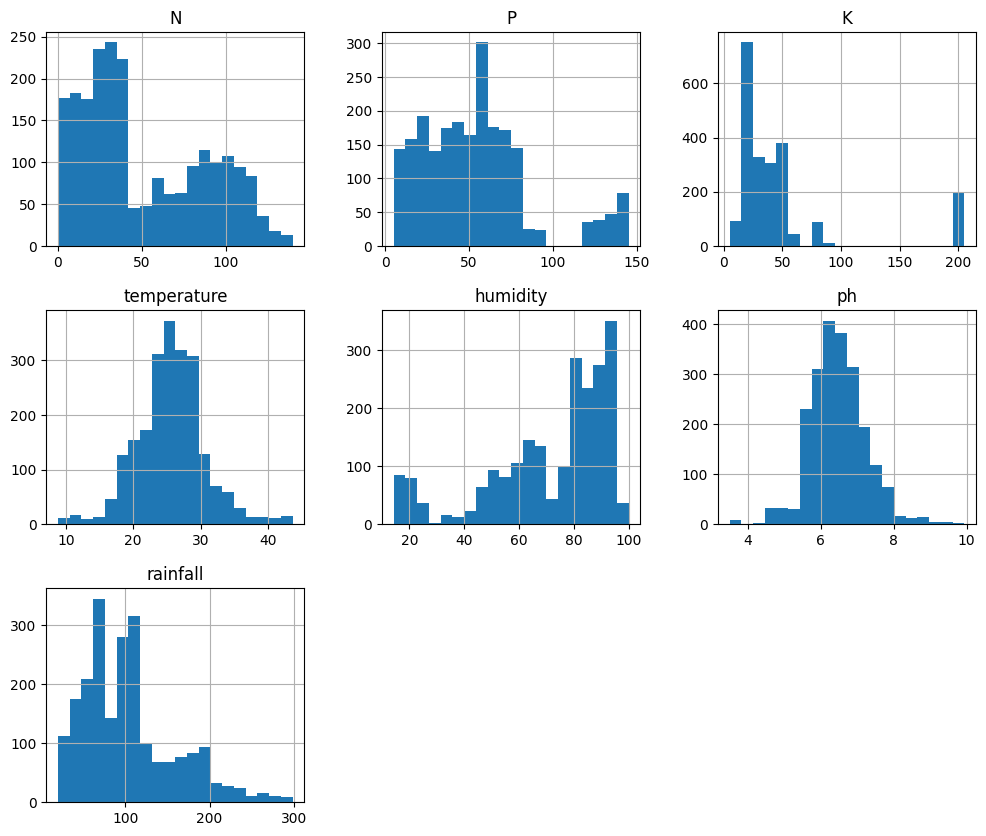

In [12]:
# Histograms for all features
df.hist(figsize=(12,10), bins=20)
plt.show()


### 4. Detect Outliers / Anomalies

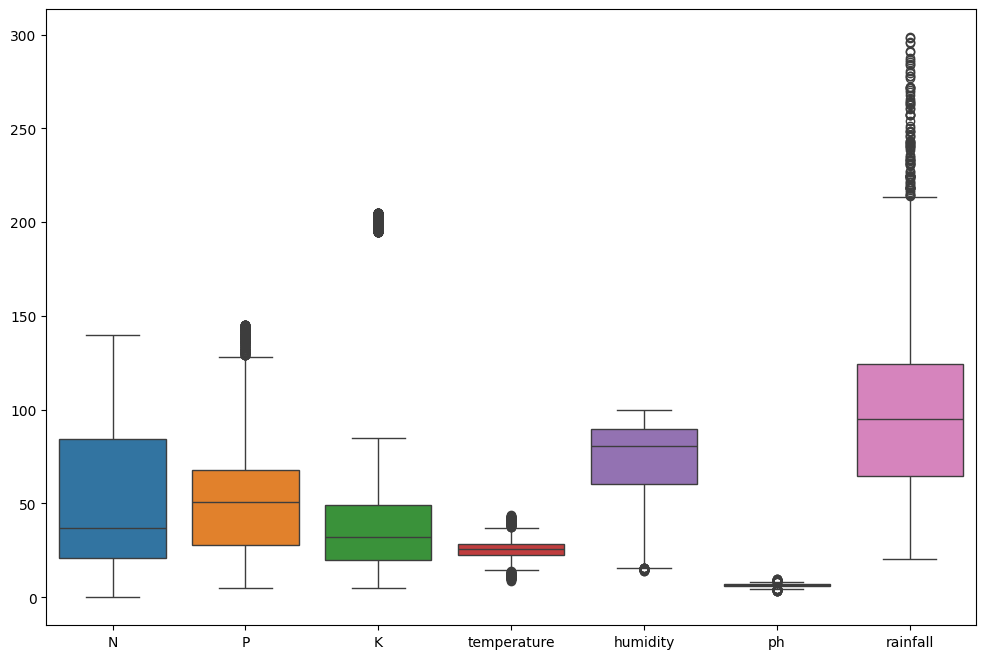

In [13]:
# Boxplot for all features
plt.figure(figsize=(12,8))
sns.boxplot(data=df)
plt.show()


### 5. Target Variable Analysis

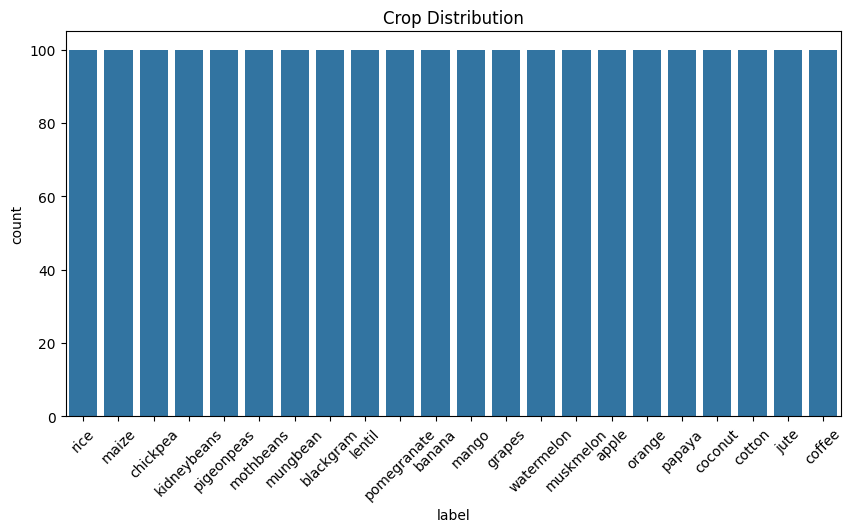

In [14]:
plt.figure(figsize=(10,5))
sns.countplot(x='label', data=df)
plt.title("Crop Distribution")
plt.xticks(rotation=45)
plt.show()


## **Preprocessing**

### 1. Encode Target Labels

In [15]:
crop_names = [
    'rice', 'maize', 'chickpea', 'kidneybeans', 'pigeonpeas', 'mothbeans',
    'mungbean', 'blackgram', 'lentil', 'pomegranate', 'banana', 'mango',
    'grapes', 'watermelon', 'muskmelon', 'apple', 'orange', 'papaya',
    'coconut', 'cotton', 'jute', 'coffee'
]

le = LabelEncoder()
le.fit(crop_names)

LabelEncoder()

### 2. Split Features & Target

In [16]:
y = le.transform(df['label'])
X = df.drop('label', axis=1)

### 3. Train-Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 4. Feature Scaling (for SVM & KNN)

In [18]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **1. Random Forest**

In [19]:
# random forest training
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [20]:
# Prediction
y_pred_rf = rf.predict(X_test_scaled)

In [21]:
print("✅ Accuracy:", round(accuracy_score(y_test, y_pred_rf)*100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

✅ Accuracy: 99.24 %

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        26
           3       1.00      1.00      1.00        34
           4       1.00      1.00      1.00        33
           5       1.00      1.00      1.00        30
           6       1.00      1.00      1.00        28
           7       1.00      1.00      1.00        23
           8       0.87      1.00      0.93        34
           9       1.00      1.00      1.00        36
          10       1.00      1.00      1.00        22
          11       1.00      1.00      1.00        26
          12       1.00      1.00      1.00        32
          13       1.00      1.00      1.00        34
          14       1.00      1.00      1.00        30
          15       1.00      1.00      1.00        24
          16       1.00      1.00   

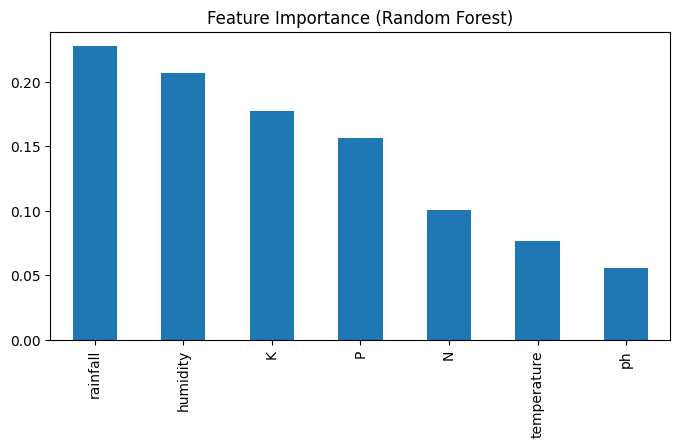

In [22]:
# Feature Importance
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(8,4), title='Feature Importance (Random Forest)')
plt.show()

In [23]:
# Define realistic ranges
feature_ranges = {
    'N': (0, 140),
    'P': (0, 140),
    'K': (0, 140),
    'temperature': (10, 45),
    'humidity': (20, 100),
    'ph': (3.5, 9.0),
    'rainfall': (20, 300)
}

# Generate one scenario
random_input = {f: np.random.uniform(low, high) if isinstance(low, float) or isinstance(high, float)
                else np.random.randint(low, high+1)
                for f, (low, high) in feature_ranges.items()}

new_data = pd.DataFrame([random_input], columns=X.columns)
new_data_scaled = scaler.transform(new_data)

# Predict numeric label
prediction = rf.predict(new_data_scaled)

# Convert to crop name
predicted_crop = le.inverse_transform(prediction)

print("\nRandom Soil & Climate Scenario:")
print(new_data.round(2))
print("\n🌾 Recommended Crop:", predicted_crop[0])















Random Soil & Climate Scenario:
    N   P   K  temperature  humidity   ph  rainfall
0  65  59  30           18        92  4.5       270

🌾 Recommended Crop: rice


# **2. Cat Boost Algorithm**

In [24]:
# Initialize CatBoost
cat = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, random_seed=42, verbose=0)

# Train
cat.fit(X_train_scaled, y_train)


In [25]:
# Prediction and Evaluate
# Predict on test set
y_pred_cat = cat.predict(X_test_scaled)

# Accuracy & Classification Report
print("✅ CatBoost Accuracy:", round(accuracy_score(y_test, y_pred_cat)*100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_cat))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_cat))


✅ CatBoost Accuracy: 98.48 %

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        26
           2       0.93      1.00      0.96        26
           3       1.00      1.00      1.00        34
           4       1.00      1.00      1.00        33
           5       1.00      1.00      1.00        30
           6       1.00      1.00      1.00        28
           7       1.00      1.00      1.00        23
           8       0.85      1.00      0.92        34
           9       0.97      1.00      0.99        36
          10       0.96      1.00      0.98        22
          11       1.00      1.00      1.00        26
          12       1.00      1.00      1.00        32
          13       1.00      0.97      0.99        34
          14       1.00      1.00      1.00        30
          15       1.00      1.00      1.00        24
          16       1.00    

In [26]:
# Generate random sample
random_input = {feature: np.random.randint(low, high)
                for feature, (low, high) in feature_ranges.items()}

# Convert to DataFrame
new_data = pd.DataFrame([random_input])

# Scale
new_data_scaled = scaler.transform(new_data)

# Predict with CatBoost
prediction_cat = cat.predict(new_data_scaled)
predicted_crop_cat = le.inverse_transform(prediction_cat)

print("Random Soil & Climate Scenario:")
print(new_data)
print("\n🌾 CatBoost Recommended Crop:", predicted_crop_cat[0])


Random Soil & Climate Scenario:
     N    P    K  temperature  humidity  ph  rainfall
0  123  121  131           43        85   8       261

🌾 CatBoost Recommended Crop: papaya


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# **3. XGBoost Algorithm**

In [27]:
# Initialize XGBoost
xgb = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=6, random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Train
xgb.fit(X_train_scaled, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [06:42:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [28]:
# Predict on test set
y_pred_xgb = xgb.predict(X_test_scaled)

# Accuracy & Report
print("✅ XGBoost Accuracy:", round(accuracy_score(y_test, y_pred_xgb)*100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


✅ XGBoost Accuracy: 98.18 %

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       0.96      1.00      0.98        26
           2       0.96      1.00      0.98        26
           3       1.00      1.00      1.00        34
           4       1.00      1.00      1.00        33
           5       1.00      1.00      1.00        30
           6       0.97      1.00      0.98        28
           7       1.00      1.00      1.00        23
           8       0.85      1.00      0.92        34
           9       1.00      1.00      1.00        36
          10       1.00      0.95      0.98        22
          11       0.96      0.96      0.96        26
          12       0.97      1.00      0.98        32
          13       0.97      1.00      0.99        34
          14       1.00      1.00      1.00        30
          15       1.00      1.00      1.00        24
          16       1.00     

In [29]:
# Predict on previously generated random scenario
random_input = {feature: np.random.randint(low, high)
                for feature, (low, high) in feature_ranges.items()}

# Convert to DataFrame
new_data = pd.DataFrame([random_input])

# Scale
new_data_scaled = scaler.transform(new_data)
prediction_xgb = xgb.predict(new_data_scaled)
predicted_crop_xgb = le.inverse_transform(prediction_xgb)

print("Random Soil & Climate Scenario:")
print(new_data)
print("\n🌾 XGBoost Recommended Crop:", predicted_crop_xgb[0])


Random Soil & Climate Scenario:
    N   P    K  temperature  humidity  ph  rainfall
0  82  34  114           32        91   6       228

🌾 XGBoost Recommended Crop: papaya


#**4. SVM (Support Vector Machine)**

In [30]:
# Train SVM
svm_model = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm_model.fit(X_train_scaled, y_train)

SVC(C=1, random_state=42)

In [31]:
# Evaluate SVM
y_pred = svm_model.predict(X_test_scaled)

In [32]:
print("✅ SVM Accuracy:", round(accuracy_score(y_test, y_pred)*100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

✅ SVM Accuracy: 97.27 %

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        26
           2       0.93      0.96      0.94        26
           3       1.00      1.00      1.00        34
           4       1.00      1.00      1.00        33
           5       1.00      1.00      1.00        30
           6       0.97      1.00      0.98        28
           7       1.00      1.00      1.00        23
           8       0.79      1.00      0.88        34
           9       0.95      1.00      0.97        36
          10       0.85      1.00      0.92        22
          11       1.00      0.96      0.98        26
          12       1.00      1.00      1.00        32
          13       1.00      0.91      0.95        34
          14       1.00      1.00      1.00        30
          15       1.00      1.00      1.00        24
          16       1.00      1.0

In [33]:
random_input = {feature: np.random.uniform(low, high) if isinstance(low, float) or isinstance(high, float)
                else np.random.randint(low, high+1)
                for feature, (low, high) in feature_ranges.items()}

# Convert to DataFrame
new_data = pd.DataFrame([random_input], columns=X.columns)

# Scale features
new_data_scaled = scaler.transform(new_data)

# Predict numeric label using SVM
prediction = svm_model.predict(new_data_scaled)

# Convert numeric label to crop name
predicted_crop = le.inverse_transform(prediction)

# Output
print("\nRandom Soil & Climate Scenario:")
print(new_data.round(2))

print("\n🌾 Recommended Crop:", predicted_crop[0])


Random Soil & Climate Scenario:
     N   P  K  temperature  humidity    ph  rainfall
0  135  18  2           29        56  8.19       115

🌾 Recommended Crop: coffee


# **5. K-Nearest Neighbors (KNN)**

In [34]:
# Initialize KNN
knn = KNeighborsClassifier(n_neighbors=5)

In [35]:
# Train KNN
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [36]:
# Predict on test set
y_pred_knn = knn.predict(X_test_scaled)

In [37]:
# Accuracy and report
print("✅ KNN Accuracy:", round(accuracy_score(y_test, y_pred_knn)*100, 2), "%")
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))

✅ KNN Accuracy: 96.06 %

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        26
           2       0.89      0.96      0.93        26
           3       1.00      1.00      1.00        34
           4       1.00      1.00      1.00        33
           5       0.97      0.97      0.97        30
           6       0.97      1.00      0.98        28
           7       1.00      1.00      1.00        23
           8       0.79      0.97      0.87        34
           9       0.95      1.00      0.97        36
          10       0.81      1.00      0.90        22
          11       1.00      0.96      0.98        26
          12       0.91      1.00      0.96        32
          13       1.00      0.85      0.92        34
          14       1.00      1.00      1.00        30
          15       1.00      1.00      1.00        24
          16       1.00      0.9

In [38]:
random_input = {feature: np.random.uniform(low, high) if isinstance(low, float) or isinstance(high, float)
                else np.random.randint(low, high+1)
                for feature, (low, high) in feature_ranges.items()}

new_data = pd.DataFrame([random_input], columns=X.columns)
new_data_scaled = scaler.transform(new_data)

# Predict numeric label
prediction = knn.predict(new_data_scaled)

# Convert numeric label to crop name
predicted_crop = le.inverse_transform(prediction)

# Output
print("\nRandom Soil & Climate Scenario:")
print(new_data.round(2))
print("\n🌾 KNN Recommended Crop:", predicted_crop[0])


Random Soil & Climate Scenario:
     N    P    K  temperature  humidity   ph  rainfall
0  132  127  134           27        46  5.0       174

🌾 KNN Recommended Crop: banana


In [39]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

# Suppose this is your chosen soil & climate scenario
new_data = pd.DataFrame([{
    'N': 90,
    'P': 42,
    'K': 43,
    'temperature': 20.8,
    'humidity': 82.0,
    'ph': 6.5,
    'rainfall': 202.9
}], columns=X.columns)

# Scale features
new_data_scaled = scaler.transform(new_data)

# ---- Random Forest ----
rf_prediction = rf.predict(new_data_scaled)
rf_crop = le.inverse_transform(rf_prediction)
rf_accuracy = round(accuracy_score(y_test, y_pred_rf)*100, 2)

# ---- SVM ----
svm_prediction = svm_model.predict(new_data_scaled)
svm_crop = le.inverse_transform(svm_prediction)
svm_accuracy = round(accuracy_score(y_test, y_pred)*100, 2)

# ---- CatBoost ----
cat_prediction = cat.predict(new_data_scaled)
cat_crop = le.inverse_transform(cat_prediction)
cat_accuracy = round(accuracy_score(y_test, y_pred_cat)*100, 2)

# ---- XGBoost ----
xgb_prediction = xgb.predict(new_data_scaled)
xgb_crop = le.inverse_transform(xgb_prediction)
xgb_accuracy = round(accuracy_score(y_test, y_pred_xgb)*100, 2)

# ---- KNN ----
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
knn_prediction = knn_model.predict(new_data_scaled)
knn_crop = le.inverse_transform(knn_prediction)
y_pred_knn = knn_model.predict(X_test_scaled)
knn_accuracy = round(accuracy_score(y_test, y_pred_knn)*100, 2)

# Prepare results table
results = pd.DataFrame({
    'Model': ['Random Forest', 'SVM', 'CatBoost', 'XGBoost', 'KNN'],
    'Predicted Crop': [rf_crop[0], svm_crop[0], cat_crop[0], xgb_crop[0], knn_crop[0]],
    'Accuracy (%)': [rf_accuracy, svm_accuracy, cat_accuracy, xgb_accuracy, knn_accuracy]
})

print("\nSoil & Climate Scenario:")
print(new_data.round(2))

print("\n🌾 Predictions & Accuracies:")
print(results)



Soil & Climate Scenario:
    N   P   K  temperature  humidity   ph  rainfall
0  90  42  43         20.8      82.0  6.5     202.9

🌾 Predictions & Accuracies:
           Model Predicted Crop  Accuracy (%)
0  Random Forest           rice         99.24
1            SVM           rice         97.27
2       CatBoost           rice         98.48
3        XGBoost           rice         98.18
4            KNN           rice         96.06


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
